# Autocorrelation analysis of Berlin by number of airbnbs and hotels/neighborhood

In [51]:
import esda
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
import libpysal as lp
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline

## Read csv and preprocess

In [52]:
airbnb_listings = pd.read_csv(
    "../../data - AirBnb/listings.csv.gz", compression='gzip', on_bad_lines='skip')
neighbourhoods_gdf = gpd.read_file(
    "../../data - AirBnb/neighbourhoods.geojson"
)

# convert price to float
airbnb_listings['price'] = airbnb_listings['price'].str.replace('$', '').str.replace(',', '').astype(float)

# filter out outliers
airbnb_listings = airbnb_listings[airbnb_listings['price'] < 1000]

median = airbnb_listings['price'].median()

# use only 'neighbourhood_cleansed'
airbnb_listings['neighbourhood'] = airbnb_listings['neighbourhood_cleansed']

In [53]:
hotels_df = pd.read_csv('../../data - Tourpedia/berlin-accommodation_v2.csv', sep = ';')

# assign hotels to neighbourhoods based on coordinates
geometry = [Point(xy) for xy in zip(hotels_df['lng'], hotels_df['lat'])]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(hotels_df, crs=crs, geometry=geometry)
neighbourhoods_gdf['hotel_count'] = 0

for idx, poly in neighbourhoods_gdf.iterrows():
    count = geo_df.within(poly['geometry']).sum()
    neighbourhoods_gdf.at[idx, 'hotel_count'] = count

/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [54]:
# group by neighbourhood and calculate sum of rows per neighborhood
airbnb_listings = airbnb_listings.groupby('neighbourhood').count()[['id']]
airbnb_listings['airbnb_count'] = airbnb_listings['id']

In [55]:
neighbourhoods_gdf.set_index('neighbourhood', inplace=True)
neighbourhoods_gdf = neighbourhoods_gdf.merge(airbnb_listings, left_index=True, right_index=True)

In [56]:
neighbourhoods_gdf.head()

,neighbourhood_group,geometry,hotel_count,id,airbnb_count
neighbourhood,,,,,
Adlershof,Treptow - Köpenick,"MULTIPOLYGON (((13.55429 52.42581, 13.55424 52...",3,37,37
Albrechtstr.,Steglitz - Zehlendorf,"MULTIPOLYGON (((13.32681 52.46139, 13.32700 52...",3,50,50
Alexanderplatz,Mitte,"MULTIPOLYGON (((13.40559 52.52967, 13.40721 52...",29,725,725
Allende-Viertel,Treptow - Köpenick,"MULTIPOLYGON (((13.58666 52.44096, 13.58587 52...",0,2,2
Alt Treptow,Treptow - Köpenick,"MULTIPOLYGON (((13.43966 52.48991, 13.43967 52...",1,53,53


Visualization of the distribution of airbnb's per neighborhood

<Axes: title={'center': 'Airbnb listings per neighbourhood'}>

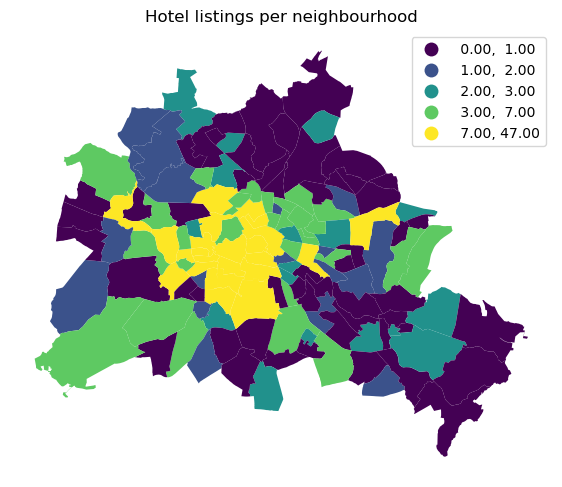

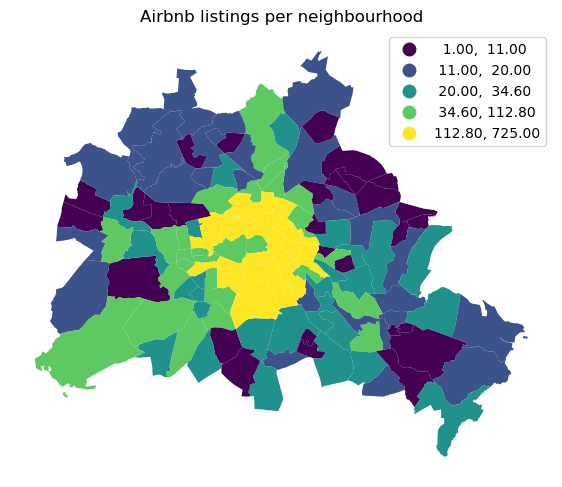

In [57]:

f, ax = plt.subplots(1, figsize=(7, 7))
ax.set_title('Hotel listings per neighbourhood')
ax.set_axis_off()
neighbourhoods_gdf.plot(column='hotel_count', legend=True, figsize=(7, 7), scheme='quantiles', ax=ax)

f, ax = plt.subplots(1, figsize=(7, 7))
ax.set_title('Airbnb listings per neighbourhood')
ax.set_axis_off()
neighbourhoods_gdf.plot(column='airbnb_count', legend=True, figsize=(7, 7), scheme='quantiles',  ax=ax)

Above we see the distribution of hotels as well as airbnbs across berlin.

In [58]:
# convert multi-polygons to polygons. Luckily, for this dataset, all of the multi polygons contain just one polygon
neighbourhoods_gdf['geometry'] = neighbourhoods_gdf['geometry'].apply(lambda x: x.geoms[0])

wq =  lp.weights.Queen.from_dataframe(neighbourhoods_gdf)
wq.transform = 'r'


/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:23: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if shape.type.lower() == "polygon":
/home/christoph/miniconda3/envs/dop-ex2/lib/python3.12/site-packages/libpysal/weights/_contW_lists.py:26: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  elif shape.type.lower() == "linestring":


In [59]:
y_airbnb = neighbourhoods_gdf['airbnb_count']
ylag_aribnb = lp.weights.lag_spatial(wq, y_airbnb)

y_hotel = neighbourhoods_gdf['hotel_count']
ylag_hotel = lp.weights.lag_spatial(wq, y_airbnb)


In [60]:
import mapclassify as mc
ylagq5_airbnb = mc.Quantiles(ylag_aribnb, k=5)
ylagq5_hotel = mc.Quantiles(ylag_hotel, k=5)

The below map for the spatial lag enhances the impression of similarity in space.

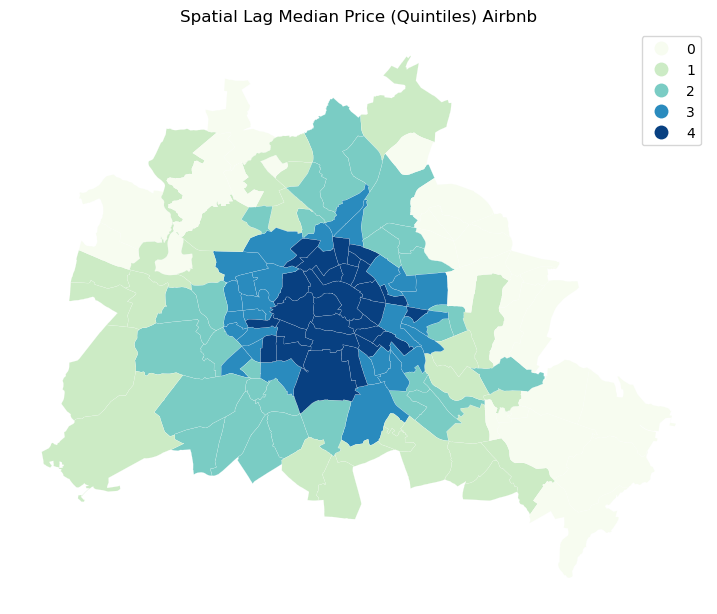

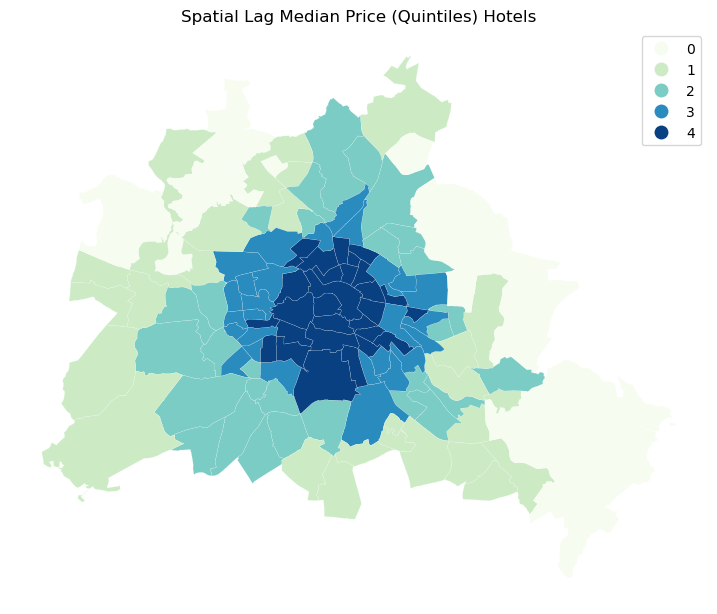

In [61]:
for ylagq5 in [ylagq5_airbnb, ylagq5_hotel]:
        f, ax = plt.subplots(1, figsize=(9, 9))
        neighbourhoods_gdf.assign(cl=ylagq5.yb).plot(column='cl', categorical=True,
                k=5, cmap='GnBu', linewidth=0.1, ax=ax, figsize=(7,7),
                edgecolor='white', legend=True)
        ax.set_axis_off()
        plt.title("Spatial Lag Median Price (Quintiles) " +  ("Airbnb" if ylagq5 == ylagq5_airbnb else "Hotels"))

        plt.show()


In [62]:
yb_airbnb = y_airbnb > y_airbnb.median()
yb_hotel = y_hotel > y_hotel.median()

In [63]:
yb_airbnb = y_airbnb > y_airbnb.median()
labels_airbnb = ["0 Low", "1 High"]
yb_airbnb = [labels_airbnb[i] for i in 1*yb_airbnb] 
neighbourhoods_gdf['yb_airbnb'] = yb_airbnb

yb_hotel = y_airbnb > y_airbnb.median()
labels_airbnb = ["0 Low", "1 High"]
yb_hotel = [labels_airbnb[i] for i in 1*yb_hotel] 
neighbourhoods_gdf['yb_hotel'] = yb_hotel

In [64]:
wq.transform = 'r'
lag_price_airbnb = lp.weights.lag_spatial(wq, neighbourhoods_gdf['airbnb_count'])
lag_price_hotel = lp.weights.lag_spatial(wq, neighbourhoods_gdf['hotel_count'])

In [65]:
li_airbnb = esda.moran.Moran_Local(y_airbnb, wq)
li_hotel = esda.moran.Moran_Local(y_hotel, wq)



In [66]:
sig_airbnb = li_airbnb.p_sim < 0.05
sig_hotel = li_hotel.p_sim < 0.05

hotspot_airbnb = sig_airbnb * li_airbnb.q==1
coldspot_airbnb = sig_airbnb * li_airbnb.q==3

hotspot_hotel = sig_hotel * li_hotel.q==1
coldspot_hotel = sig_hotel * li_hotel.q==3


In [67]:
spots = ['n.sig.', 'hot spot']
labels_airbnb = [spots[i] for i in hotspot_airbnb*1]
labels_hotel = [spots[i] for i in hotspot_hotel*1]


# Hot Spots and cold spots

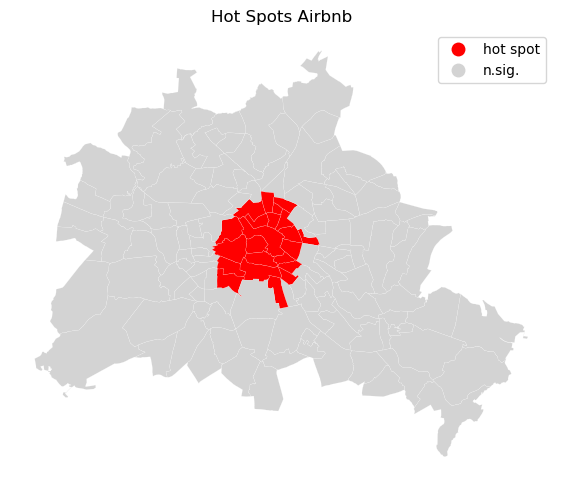

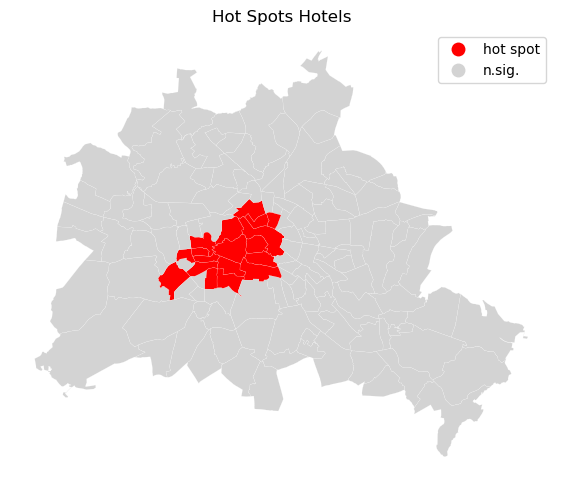

In [68]:
from matplotlib import colors

for labels in [labels_airbnb, labels_hotel]:
        neighbourhoods_gdf = neighbourhoods_gdf
        hmap = colors.ListedColormap(['red', 'lightgrey'])
        f, ax = plt.subplots(1, figsize=(7, 7))
        ax.set_title("Hot Spots " + ("Airbnb" if labels == labels_airbnb else "Hotels"))
        neighbourhoods_gdf.assign(cl=labels).plot(column='cl', categorical=True, 
                k=2, cmap=hmap, linewidth=0.1, ax=ax, 
                edgecolor='white', legend=True)
        ax.set_axis_off()
        plt.show()


In [69]:
spots = ['n.sig.', 'cold spot']
labels_airbnb = [spots[i] for i in coldspot_airbnb*1]
labels_hotel = [spots[i] for i in coldspot_hotel*1]


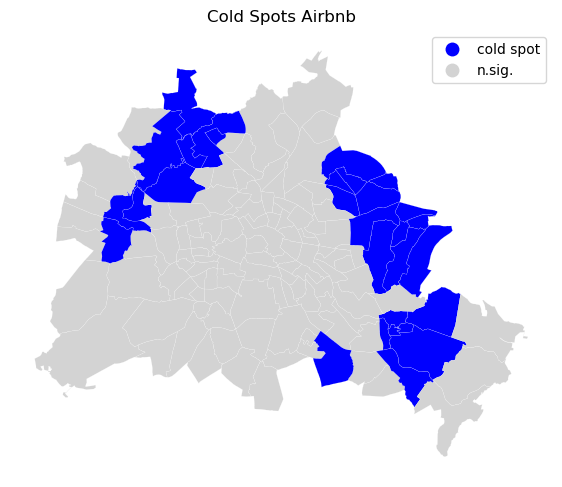

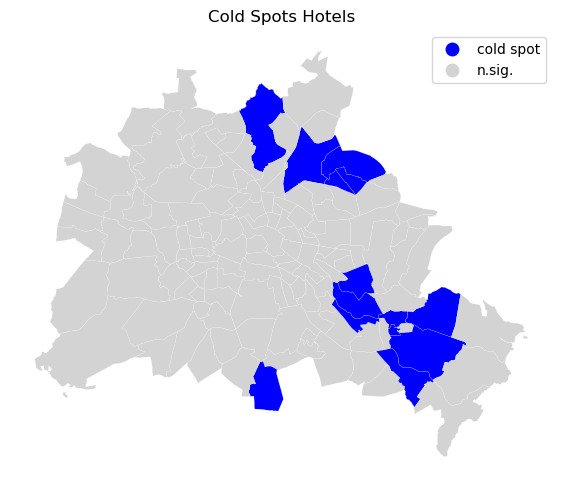

In [70]:
for labels in [labels_airbnb, labels_hotel]:
        neighbourhoods_gdf = neighbourhoods_gdf
        hmap = colors.ListedColormap(['blue', 'lightgrey'])
        f, ax = plt.subplots(1, figsize=(7, 7))
        ax.set_title("Cold Spots " + ("Airbnb" if labels == labels_airbnb else "Hotels"))
        neighbourhoods_gdf.assign(cl=labels).plot(column='cl', categorical=True, 
                k=2, cmap=hmap, linewidth=0.1, ax=ax, 
                edgecolor='white', legend=True)
        ax.set_axis_off()
        plt.show()
